## Import libraries

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from textwrap import wrap

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelSpreading
from numpy import concatenate

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score

## Import Datasets

In [3]:
data1_df = pd.read_csv('Constraint_train.csv', index_col = 'id')
data2_df = pd.read_csv('Constraint_Val.csv', index_col = 'id')
data3_df = pd.read_csv('english_test_with_labels.csv', index_col = 'id')

In [4]:
combined_df =  pd.concat([data1_df, data2_df, data2_df], ignore_index = True)

In [5]:
combined_df.dropna(inplace = True)

In [6]:
#write dataframe to file
combined_df.to_csv("combined_df.csv")

In [7]:
combined_df

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real
...,...,...
10695,Donald Trump wrongly claimed that New Zealand ...,fake
10696,Current understanding is #COVID19 spreads most...,real
10697,Nothing screams “I am sat around doing fuck al...,fake
10698,Birx says COVID-19 outbreak not under control ...,fake


## Labeling the dataset 
### Real = 1 & Fake = 0

In [8]:
combined_df = combined_df.replace(to_replace='real', value=1)
combined_df= combined_df.replace(to_replace='fake', value=0)       

In [9]:
combined_df

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1
...,...,...
10695,Donald Trump wrongly claimed that New Zealand ...,0
10696,Current understanding is #COVID19 spreads most...,1
10697,Nothing screams “I am sat around doing fuck al...,0
10698,Birx says COVID-19 outbreak not under control ...,0


### Functions

In [10]:
# TO REMOVE NUMBERS FROM TWEET(TEXT)
def preprocess_text(text):
  text = re.sub(r'\d+', '', text)
  return text

# VECTORIZE TWEETS
def tfidf_vectorize(df, text_col, normalize_data=False):
  df_copy = df.copy().reset_index(drop=True, inplace=False)
  tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7, strip_accents="ascii", preprocessor=preprocess_text)
  vectorized = tfidf_vectorizer.fit_transform(df[text_col])

  if normalize_data == True:
    vectorized_arr_norm = normalize(vectorized)
    vectorized_arr = vectorized_arr_norm.toarray()

  elif normalize_data == False: 
    vectorized_arr = vectorized.toarray()

  df_vector = pd.DataFrame(vectorized_arr, columns = tfidf_vectorizer.get_feature_names())

  df_tfidf = pd.concat([df_copy, df_vector], axis=1)
  return df_tfidf

In [11]:
df_tfidf = tfidf_vectorize(combined_df, 'tweet')

In [12]:
y = combined_df.label

In [13]:
y

0        1
1        1
2        0
3        1
4        1
        ..
10695    0
10696    1
10697    0
10698    0
10699    1
Name: label, Length: 10700, dtype: int64

In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_df.tweet)

## Using a Supervised Learning Model to detect Real Vs Fake Tweet

## Creating a Training and Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [37]:
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.74, random_state=42, stratify=y_train)

In [38]:
print('Labeled Train Set:', X_train_lab.shape, y_train_lab.shape)
print('Unlabeled Train Set:', X_test_unlab.shape, y_test_unlab.shape)
# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (2225, 21929) (2225,)
Unlabeled Train Set: (6335, 21929) (6335,)
Test Set: (2140, 21929) (2140,)


### Training a Logistic Regression Model

In [39]:
log_clf = LogisticRegression(C=5e1, solver='lbfgs', multi_class='ovr', random_state=17, n_jobs=-1)

log_clf.fit(X_train, y_train)

LogisticRegression(C=50.0, multi_class='ovr', n_jobs=-1, random_state=17)

### Evaluating the Accuracy of the Model

In [40]:
pred_data = log_clf.predict(X_test)
score=accuracy_score(pred_data, y_test)

# summarize score
print('Accuracy: %.3f' % (score*100))

Accuracy: 96.542


##### Comment on accuracy score

### Creating a confusion matrix

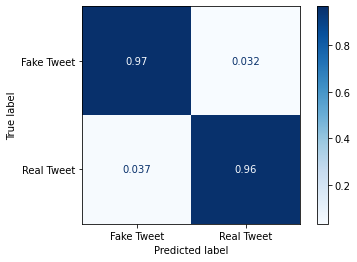

In [41]:
plot_confusion_matrix(log_clf, X_test, y_test, cmap='Blues', normalize='true',display_labels=['Fake Tweet', 'Real Tweet'])

### Generating a wordcloud

In [42]:
# WORDCLOUD GEN
def generate_word_clouds(df, n_rows, n_cols, title):
    fig=plt.figure(figsize=(10,10))
    for i, var_name in enumerate(df.columns):
        combined_text = ""
        for s in df[var_name]:
            combined_text += str(s)

        ax=fig.add_subplot(n_rows,n_cols,i+1)
        wordcloud = WordCloud( background_color='white').generate(combined_text)
        ax.imshow(wordcloud)
        ax.axis('off')
        ax.set_title("\n".join(wrap(title, 50)))
        
    ax.set_facecolor('white')
    plt.tight_layout()
    
    plt.show()

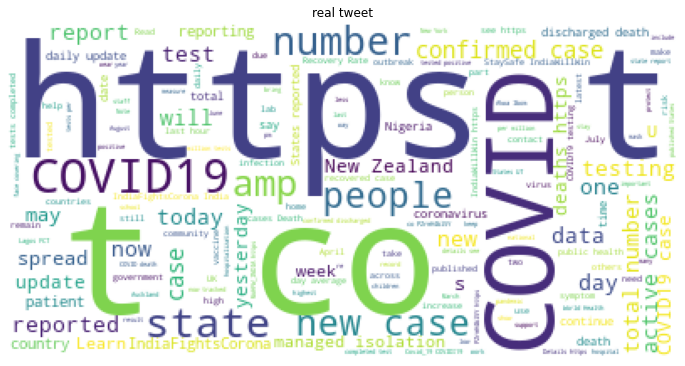

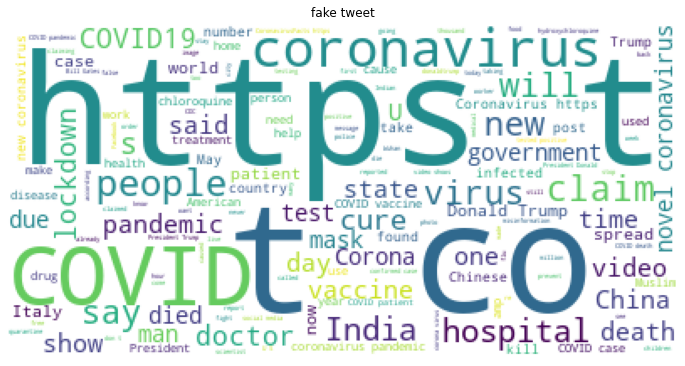

In [43]:
real_filter = combined_df["label"] == 1
real_wordcloud = combined_df[["tweet"]].where(real_filter).dropna()

generate_word_clouds(real_wordcloud, 2, 1, "real tweet")

fake_filter = combined_df["label"] == 0
fake_wordcloud = combined_df[["tweet"]].where(fake_filter).dropna()

generate_word_clouds(fake_wordcloud, 2, 1, "fake tweet")


### Visualize the class distribution

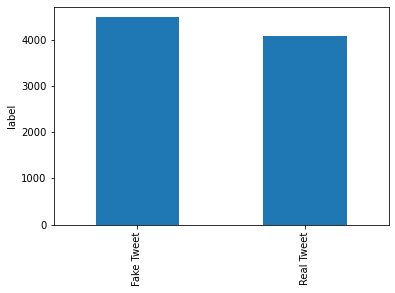

In [44]:
# Visualize class distribution
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['Fake Tweet', 'Real Tweet'])
plt.ylabel('label');

## Using Semi supervised Learning Model to detect Fake vs Real Tweet 

##### Prepare a semi-supervised learning dataset

### For Semi-Supervised Learning

In [52]:
# create the training dataset input
from scipy.sparse import vstack
X_train_mixed = vstack([X_train_lab, X_test_unlab]).toarray()

In [53]:
# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]

In [54]:
# recombine training dataset label
y_train_mixed = concatenate((y_train_lab, nolabel))

In [55]:
y_train_mixed

array([ 1,  1,  0, ..., -1, -1, -1], dtype=int64)

In [56]:
# define model

semi_supervised_model = LabelSpreading()
# fit model on training dataset
semi_supervised_model.fit(X_train_mixed, y_train_mixed)

LabelSpreading()

In [57]:
# get labels for entire training dataset data
tran_labels = semi_supervised_model.transduction_

### Evaluating the Accuracy

In [63]:
# make predictions on hold out test set
predic_data = semi_supervised_model.predict(X_test_unlab)
# calculate score for test set
score = accuracy_score(predic_data, y_test_unlab)
# summarize score
print('Accuracy: %.3f' % (score*100))

Accuracy: 90.687


### Generating Confusion Matrix

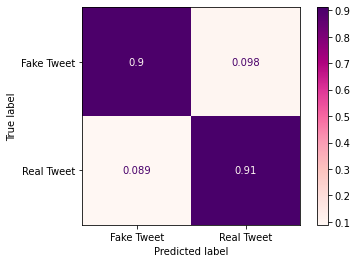

In [61]:
plot_confusion_matrix(semi_supervised_model, X_test_unlab, y_test_unlab, cmap='RdPu', normalize='true',display_labels=['Fake Tweet', 'Real Tweet'])

##### we can retrieve the labels for the entire training dataset from the label spreading model using transduction_ , We can then use these labels, along with all of the input data, to train and evaluate a supervised learning algorithm, such as a logistic regression model.

##### The hope is that the supervised learning model fit on the entire training dataset would achieve even better performance than the semi-supervised learning model alone.

In [64]:
log_clf2 = LogisticRegression(C=5e1, solver='lbfgs', multi_class='ovr', random_state=17, n_jobs=-1)

log_clf2.fit(X_train_mixed, tran_labels)

LogisticRegression(C=50.0, multi_class='ovr', n_jobs=-1, random_state=17)

In [65]:
pred_data = log_clf2.predict(X_test)
score=accuracy_score(pred_data, y_test)

# summarize score
print('Accuracy: %.3f' % (score*100))

Accuracy: 92.944


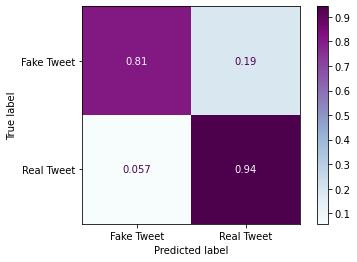

In [67]:
plot_confusion_matrix(semi_supervised_model, X_test, y_test, cmap='BuPu', normalize='true',display_labels=['Fake Tweet', 'Real Tweet'])